In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt

# Definições iniciais

In [2]:
h = 0.01
k = 0.01
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.5
X_nb = 1e-4
x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)

size_x = int(((x_dom[1] - x_dom[0]) / (h))) + 1
size_y = int(((y_dom[1] - y_dom[0]) / (h))) + 1
size_t = int(((t_dom[1] - t_dom[0]) / (k))) + 1

print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

print(
    "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
        size_t,
        size_x,
        size_y,
    )
)

CFL = (Db * k) / ((2 * (h * h)))

print("CFL: ", CFL, "\n")

if CFL >= 1:
    print("Criterio CFL não satisfeito\n")

# Computing FDM model

struct_name = (
    "h--"
    + str(h)
    + "__k--"
    + str(k)
    + "__Db--"
    + str(Db)
    + "__Dn--"
    + str(Dn)
    + "__phi--"
    + str(phi)
    + "__ksi--"
    + str(ksi)
    + "__cb--"
    + str(cb)
    + "__lambd_nb--"
    + str(lambd_nb)
    + "__mi_n--"
    + str(mi_n)
    + "__lambd_bn--"
    + str(lambd_bn)
    + "__y_n--"
    + str(y_n)
    + "__Cn_max--"
    + str(Cn_max)
    + "__X_nb--"
    + str(X_nb)
    + "__x_dom_min--"
    + str(x_dom[0])
    + "__x_dom_max--"
    + str(x_dom[-1])
    + "__y_dom_min--"
    + str(y_dom[0])
    + "__y_dom_max--"
    + str(y_dom[-1])
    + "__t_dom_min--"
    + str(t_dom[0])
    + "__t_dom_max--"
    + str(t_dom[-1])
)
print("struct_name: ", struct_name)

Size x = 101, y = 101 
 
Steps in time = 1001
Steps in space_x = 101
Steps in space_y = 101

CFL:  0.005000000000000001 

struct_name:  h--0.01__k--0.01__Db--0.0001__Dn--0.0001__phi--0.2__ksi--0.0__cb--0.15__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__Cn_max--0.5__X_nb--0.0001__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10


# Análise de nullclines

# PINN

In [3]:
with open("fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cb_fdm = pk.load(f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cn_fdm = pk.load(f)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True,dtype=np.float16)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_t, endpoint=True,dtype=np.float16)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_t, endpoint=True,dtype=np.float16)


tt, xx, yy = np.meshgrid(t_np, x_np, y_np,)

data_input_np = np.array([Cn_fdm.flatten(), Cb_fdm.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t_tc = (
        torch.tensor(tt, dtype=torch.float16, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    x_tc = (
        torch.tensor(xx, dtype=torch.float16, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    y_tc = (
        torch.tensor(yy, dtype=torch.float16, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float16).to(device)

else:
    device = torch.device("cpu")
    t_tc = torch.tensor(tt, dtype=torch.float16, requires_grad=True).reshape(-1, 1)
    x_tc = torch.tensor(xx, dtype=torch.float16, requires_grad=True).reshape(-1, 1)
    y_tc = torch.tensor(yy, dtype=torch.float16, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float16)

print(device)

del xx
del yy
del tt

cuda


In [4]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [5]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [6]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](3, int(out_neurons)))

                else:
                    modules.append(nn.Linear(3, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [7]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [8]:
def normalize_torch(dataset):
    with torch.no_grad():
        dt_min = torch.min(dataset, 0).values
        dt_max = torch.max(dataset, 0).values
        normalized = (dataset - dt_min) / (dt_max - dt_min)

    return normalized.requires_grad_(True), dt_min, dt_max

In [9]:
def normalize_data_input(data_input, steps):
    with torch.no_grad():
        dataset = data_input.reshape(steps, steps, 2)
        normalized = torch.zeros_like(dataset)
        for i in range(len(dataset)):
            dt_min = torch.min(dataset[i], 0).values
            dt_max = torch.max(dataset[i], 0).values
            normalized[i] = (dataset[i] - dt_min) / (dt_max - dt_min)

    return normalized.reshape((steps) * (steps), 2)

In [10]:
def rescale(dataset, dt_min, dt_max):
    return (dt_max - dt_min) * dataset + dt_min

In [11]:
def shuffle_data(x, y, z):
    Data_num = np.arange(x.shape[0])
    np.random.shuffle(Data_num)

    return x[Data_num], y[Data_num], z[Data_num]

In [12]:
def train_test_split(x, y, z, test_size=0.5, shuffle=True):
    with torch.no_grad():
        if shuffle:
            x, y, z = shuffle_data(x, y, z)
        if test_size < 1:
            train_ratio = len(x) - int(len(x) * test_size)
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            y_train, y_test = y[:train_ratio], y[train_ratio:]
            z_train, z_test = z[:train_ratio], z[train_ratio:]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )
        elif test_size in range(1, len(x)):
            x_train, x_test = x[test_size:], x[:test_size]
            y_train, y_test = y[test_size:], y[:test_size]
            z_train, z_test = z[test_size:], z[:test_size]
            return (
                x_train.requires_grad_(True),
                x_test.requires_grad_(True),
                y_train.requires_grad_(True),
                y_test.requires_grad_(True),
                z_train.requires_grad_(True),
                z_test.requires_grad_(True),
            )

In [13]:
def gerenate_training_points(num_points, device):
    x = torch.rand(num_points, 1).to(device)
    y = torch.rand(num_points, 1).to(device)
    t = torch.rand(num_points, 1).to(device) * 10

    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True)

In [14]:
def gerenate_boundary_points(num_points, device):
    x_boundary = torch.tensor([0.0, 1.0]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points)

    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
        n = torch.tensor([[0.0, -1.0], [0.0, 1.0]]).repeat(num_points // 2, 1)
    else:
        n = torch.tensor([[-1.0, 0.0], [1.0, 0.0]]).repeat(num_points // 2, 1)

    return (
        x_boundary.to(device).requires_grad_(True).view(-1,1),
        y_boundary.to(device).requires_grad_(True).view(-1,1),
        n.to(device),
    )

In [15]:
def initial_condition(x, y):

    Cl = torch.full_like(x, 0)

    Cp = torch.full_like(x, 0)

    for i, (xx, yy) in enumerate(zip(x, y)):
        if ((xx >= 0.5) and (xx <= 0.6)) and ((yy >= 0.5) and (yy <= 0.6)):
            Cp[i] = 0.2

    return torch.cat([Cl, Cp], dim=1)

In [16]:
def boundary_condition(x_b, y_b, t_b, n, model, Dn, X_nb, Db):
    
    input_data = torch.cat([x_b, y_b, t_b], dim=1)

    Cp, Cl = model(input_data).tensor_split(2, dim=1)

    nx, ny = n.tensor_split(2, dim=1)

    if nx[0].item() != 0:
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dx[0]) - X_nb * torch.mul(Cl, dCp_dx[0])), nx
        )

        Cp_boundary = torch.mul((Db * dCp_dx[0]), nx)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    else:
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dy[0]) - X_nb * torch.mul(Cl, dCp_dy[0])), ny
        )

        Cp_boundary = torch.mul((Db * dCp_dy[0]), ny)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [17]:
def pde(model, x, y, t, cb, lambd_nb, Db, y_n, Cn_max, lambd_bn, mi_n, Dn, X_nb):
    input_data = torch.cat([x, y, t], dim=1)

    Cl, Cp = model(input_data).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = cb * Cp
    rb = lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = y_n * torch.mul(Cp, (Cn_max - Cl))
    rn = lambd_bn * torch.mul(Cl, Cp) + mi_n * Cl

    Cl_eq = (
        Dn * (dCl_dx_2 + dCl_dy_2)
        - X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [18]:
def train(
    n_epochs,
    batch_size,
    decay_rate,
    model,
    device,
    data_input,
    x,
    y,
    t,
    n_points,
    constant_properties,
    norm_weights=None,
    validation=None,
):
    dt_min, dt_max = norm_weights if norm_weights else (0, 1)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )

    if validation:
        train_data, test_data, train_t, test_t, train_dom, test_dom = train_test_split(
            data_input, t, torch.cat([x, y], dim=1), test_size=validation
        )
        train_x, train_y = train_dom.split(1, dim=1)
        test_x, test_y = test_dom.split(1, dim=1)
        train_data_input = torch.cat([train_x, train_y, train_t], dim=1)
        test_data_input = torch.cat([test_x, test_y, test_t], dim=1)

    else:
        train_data = data_input
        test_data = None
        train_data_input = torch.cat([t, train_x, train_y], dim=1)
        test_data_input = None
        train_t = t
        test_t = None
        train_x = x
        test_x = None
        train_y = y
        test_y = None

    C_pde_loss_it = torch.zeros(n_epochs).to(device)
    C_data_loss_it = torch.zeros(n_epochs).to(device)
    C_boundary_loss_it = torch.zeros(n_epochs).to(device)
    C_initial_loss_it = torch.zeros(n_epochs).to(device)
    C_initial = initial_condition(train_x, train_y).to(device)
    val_loss_it = torch.zeros(n_epochs).to(device)

    for epoch in range(n_epochs):
        for i in range(0, len(train_t), batch_size):

            # Computing intial loss
            t_initial = torch.zeros_like(train_t[i : i + batch_size])

            mesh_ini = torch.cat(
                [train_x[i : i + batch_size], train_y[i : i + batch_size], t_initial],
                dim=1,
            )

            C_initial_pred = model(mesh_ini)

            loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

            # Computing pde loss

            x_pde, y_pde, t_pde = gerenate_training_points(n_points, device)

            predicted_pde = pde(
                model,
                x_pde,
                y_pde,
                t_pde,
                constant_properties["cb"],
                constant_properties["lambd_nb"],
                constant_properties["Db"],
                constant_properties["y_n"],
                constant_properties["Cn_max"],
                constant_properties["lambd_bn"],
                constant_properties["mi_n"],
                constant_properties["Dn"],
                constant_properties["X_nb"],
            )

            loss_pde = loss_fn(
                predicted_pde,
                torch.zeros_like(predicted_pde),
            )

            # Computing boundary loss

            x_bnd, y_bnd, n_bnd = gerenate_boundary_points(n_points, device)

            predicted_boundary = boundary_condition(
                x_bnd,
                y_bnd,
                t_pde,
                n_bnd,
                model,
                constant_properties["Dn"],
                constant_properties["X_nb"],
                constant_properties["Db"],
            )

            loss_boundary = loss_fn(
                predicted_boundary,
                torch.zeros_like(predicted_boundary),
            )

            # Computing data loss

            C_pred = model(train_data_input[i : i + batch_size])

            loss_data = loss_fn(train_data[i : i + batch_size], C_pred)

            # Computing validation loss

            if validation:
                with torch.no_grad():
                    val_loss = loss_fn(test_data, model(test_data_input))

            loss = loss_initial + loss_pde + loss_boundary + loss_data * 10

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        C_pde_loss_it[epoch] = loss_pde.item()
        C_boundary_loss_it[epoch] = loss_boundary.item()
        C_initial_loss_it[epoch] = loss_initial.item()
        C_data_loss_it[epoch] = loss_data.item()
        val_loss_it[epoch] = val_loss.item() if validation else 0

        if (epoch % 100) == 0:
            print(
                f"Finished epoch {epoch+1}, latest loss {loss}, validation loss {val_loss.item()}"
                if validation
                else f"Finished epoch {epoch+1}, latest loss {loss}"
            )

    return (
        model,
        C_pde_loss_it,
        C_boundary_loss_it,
        C_initial_loss_it,
        C_data_loss_it,
        val_loss_it,
    )

In [19]:
decay_rate = 0.999
n_epochs = 300
batch_size = 156

constant_properties = {
    "h": h,
    "k": k,
    "Db": Db,
    "Dn": Dn,
    "phi": phi,
    "ksi": ksi,
    "cb": cb,
    "lambd_nb": lambd_nb,
    "mi_n": mi_n,
    "lambd_bn": lambd_bn,
    "y_n": y_n,
    "Cn_max": Cn_max,
    "X_nb": X_nb,
}

model, C_pde_loss_it, C_boundary_loss_it, C_initial_loss_it, C_data_loss_it, val_loss_it = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    device=device,
    data_input=data_input,
    x=x_tc,
    y=y_tc,
    t=t_tc,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=0.1,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.74 GiB. GPU 0 has a total capacity of 5.79 GiB of which 31.88 MiB is free. Including non-PyTorch memory, this process has 5.74 GiB memory in use. Of the allocated memory 5.65 GiB is allocated by PyTorch, and 3.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

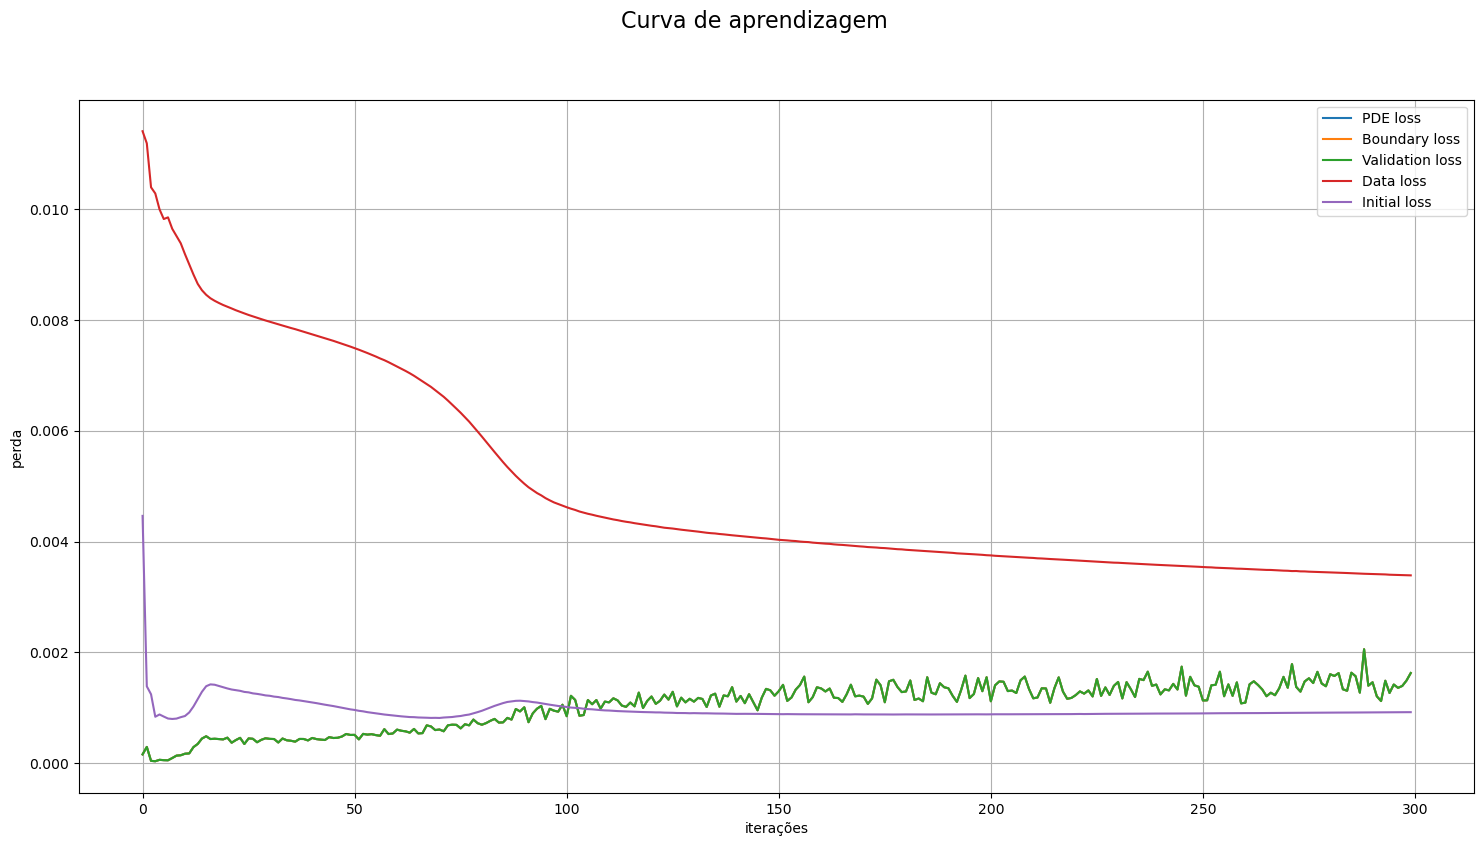

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)

ax.plot(
    range(len(C_boundary_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

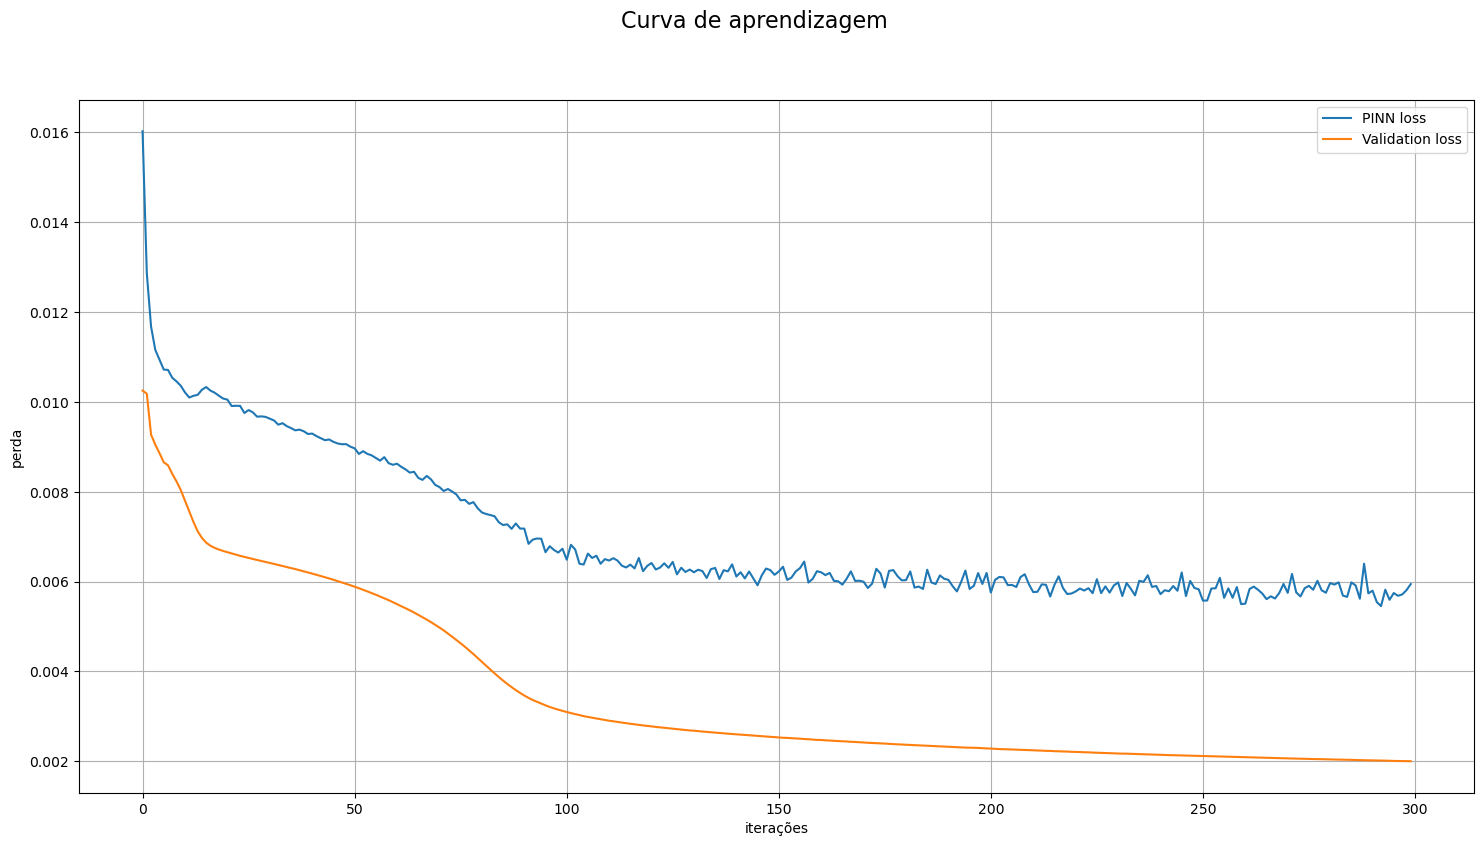

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_boundary_loss_it.cpu().numpy()
    + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [ ]:
with open("fdm_sim/time__" + struct_name + ".pkl", "rb") as f:
    time_fdm = pk.load(f)
    
model_cpu = model.to("cpu")

speed_up = []

mesh = torch.cat([x_tc, y_tc, t_tc], dim=1).to("cpu")

for i in range(len(time_fdm)):

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(mesh).split(1, dim=1)

    pinn_end = time.time()

    pinn_time = pinn_end - pinn_start

    speed_up.append(time_fdm[i] / pinn_time)

In [ ]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cn_fdm.flatten(), Cb_fdm.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cn_fdm.flatten(), Cb_fdm.flatten()
        )
    ]
)

In [ ]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [ ]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.04711977
Erro absoluto máximo 0.29254097
Speed Up: 10.644387541325615 +/-11.733799999948285


In [ ]:
Cl_pinn_np = Cl_pinn.detach().numpy().reshape(size_t , size_x , size_y )
Cp_pinn_np = Cp_pinn.detach().numpy().reshape(size_t , size_x , size_y )

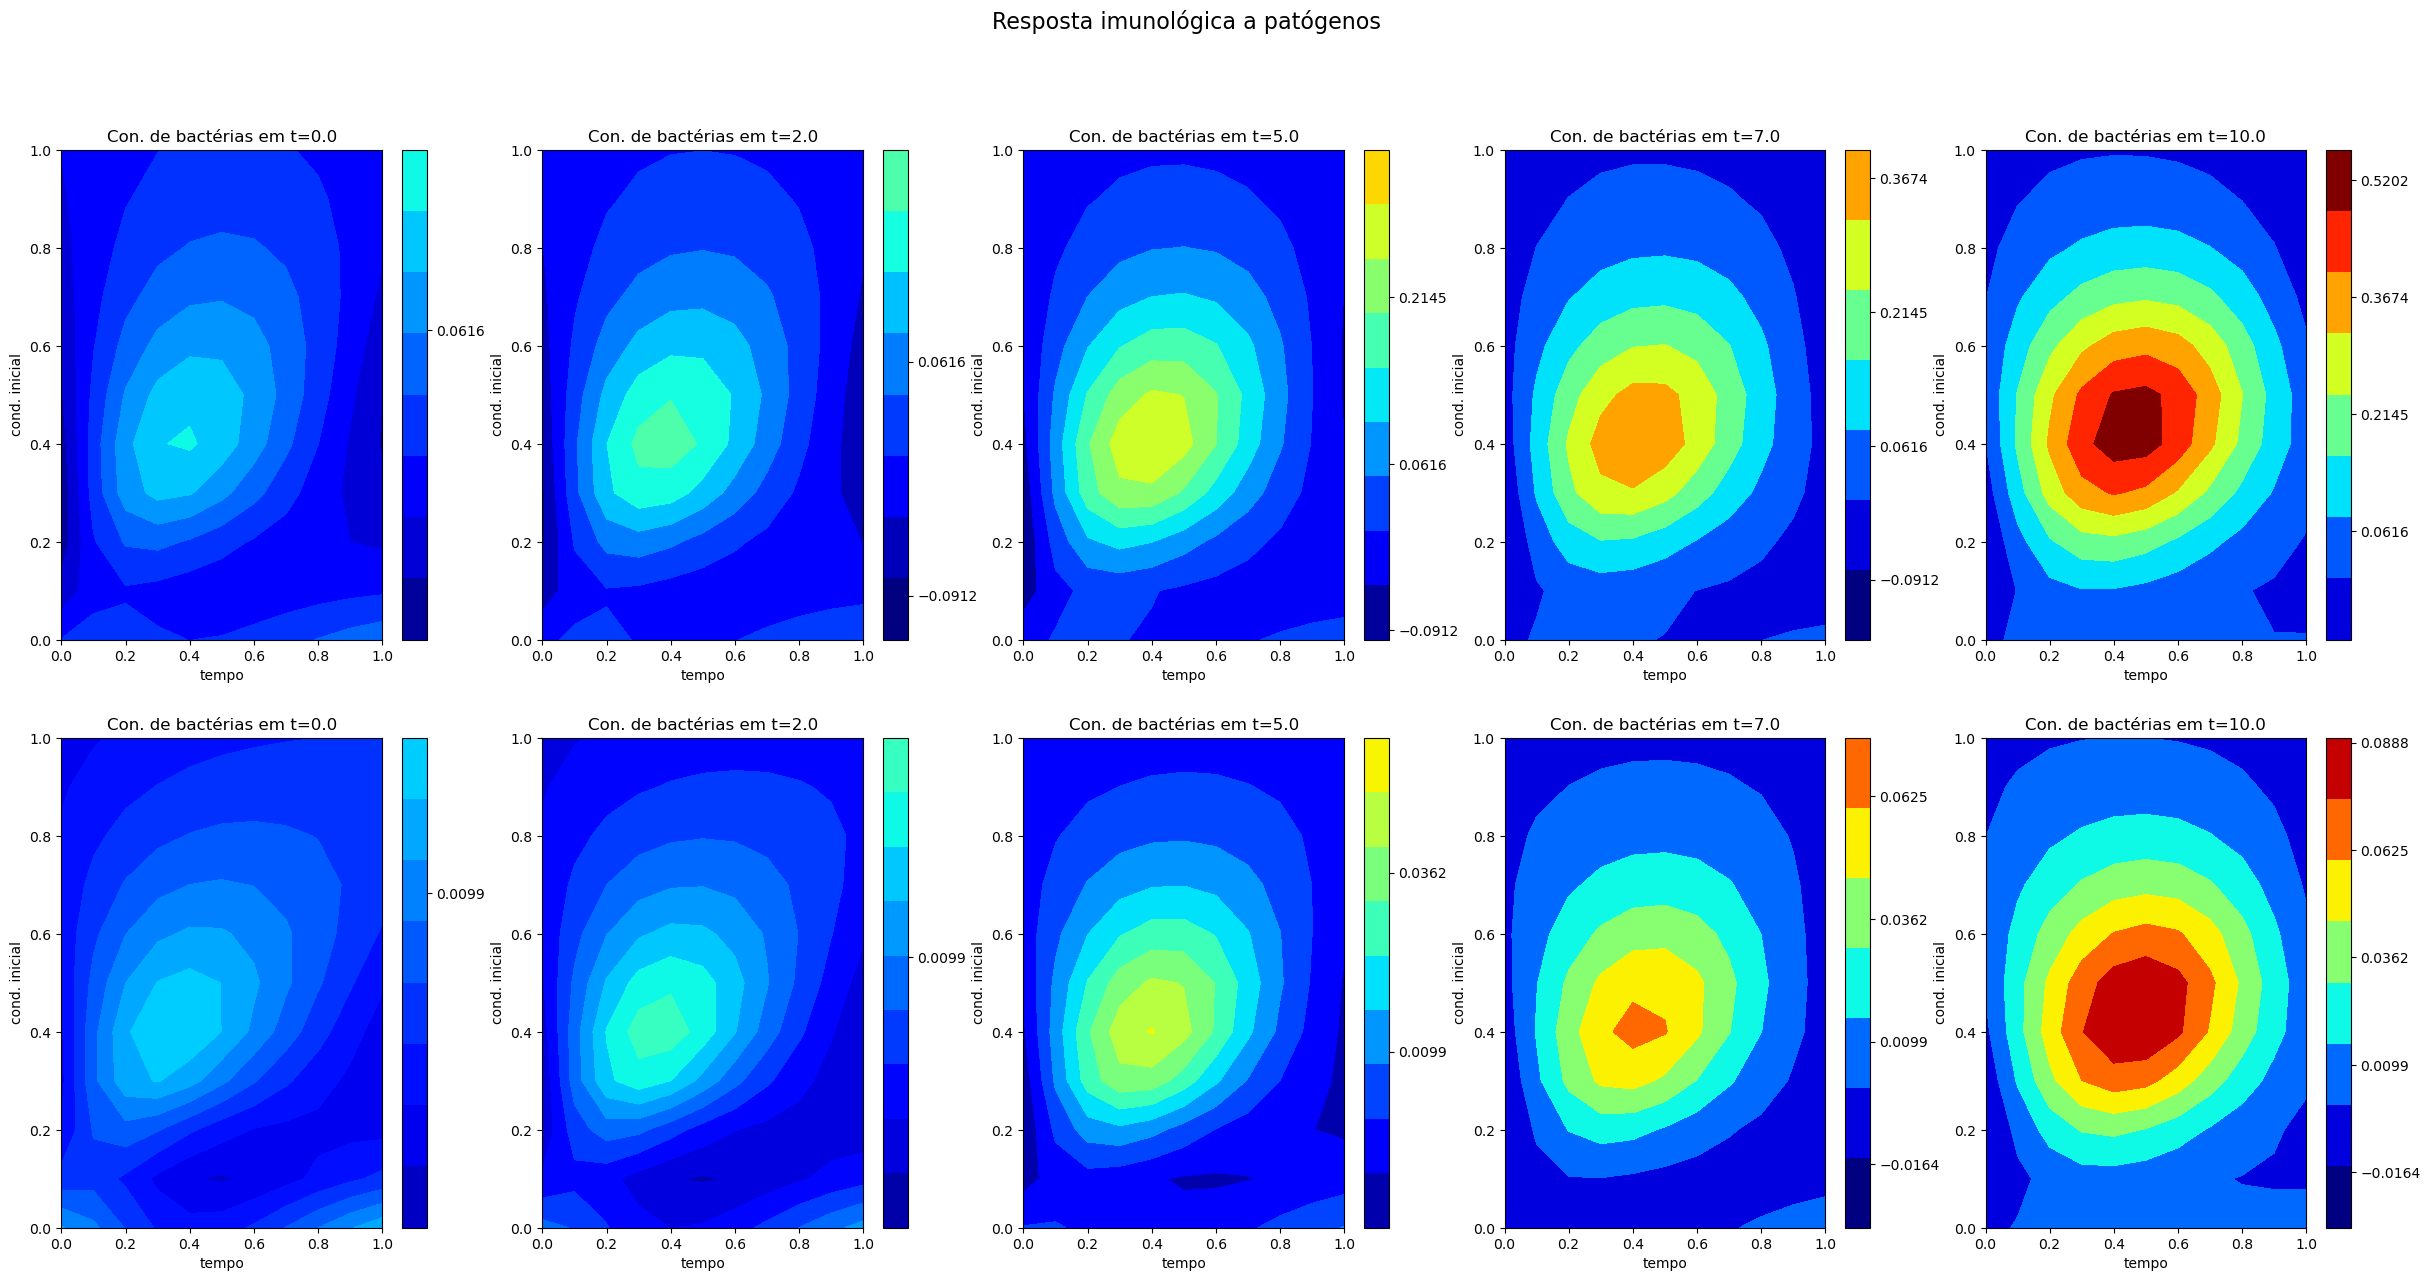

In [ ]:
x = np.linspace(x_dom[0], x_dom[1], num=size_x, endpoint=True)
y = np.linspace(y_dom[0], y_dom[1], num=size_y, endpoint=True)
t = np.linspace(t_dom[0], t_dom[1], num=size_t, endpoint=True)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, 10, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


for i, time in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

In [ ]:
Cl_pinn_np = Cl_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)
Cp_pinn_np = Cp_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)

fig = plt.figure(figsize=[18, 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

vmin = np.min(Cp_pinn_np)
vmax = np.max(Cp_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

vmin = np.min(Cl_pinn_np)
vmax = np.max(Cl_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

vmin = np.min(Cp_old)
vmax = np.max(Cp_old)

contour = ax.contourf(
    tt,
    ii,
    Cp_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

vmin = np.min(Cl_old)
vmax = np.max(Cl_old)

contour = ax.contourf(
    tt,
    ii,
    Cl_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

ValueError: cannot reshape array of size 1331 into shape (12,12)

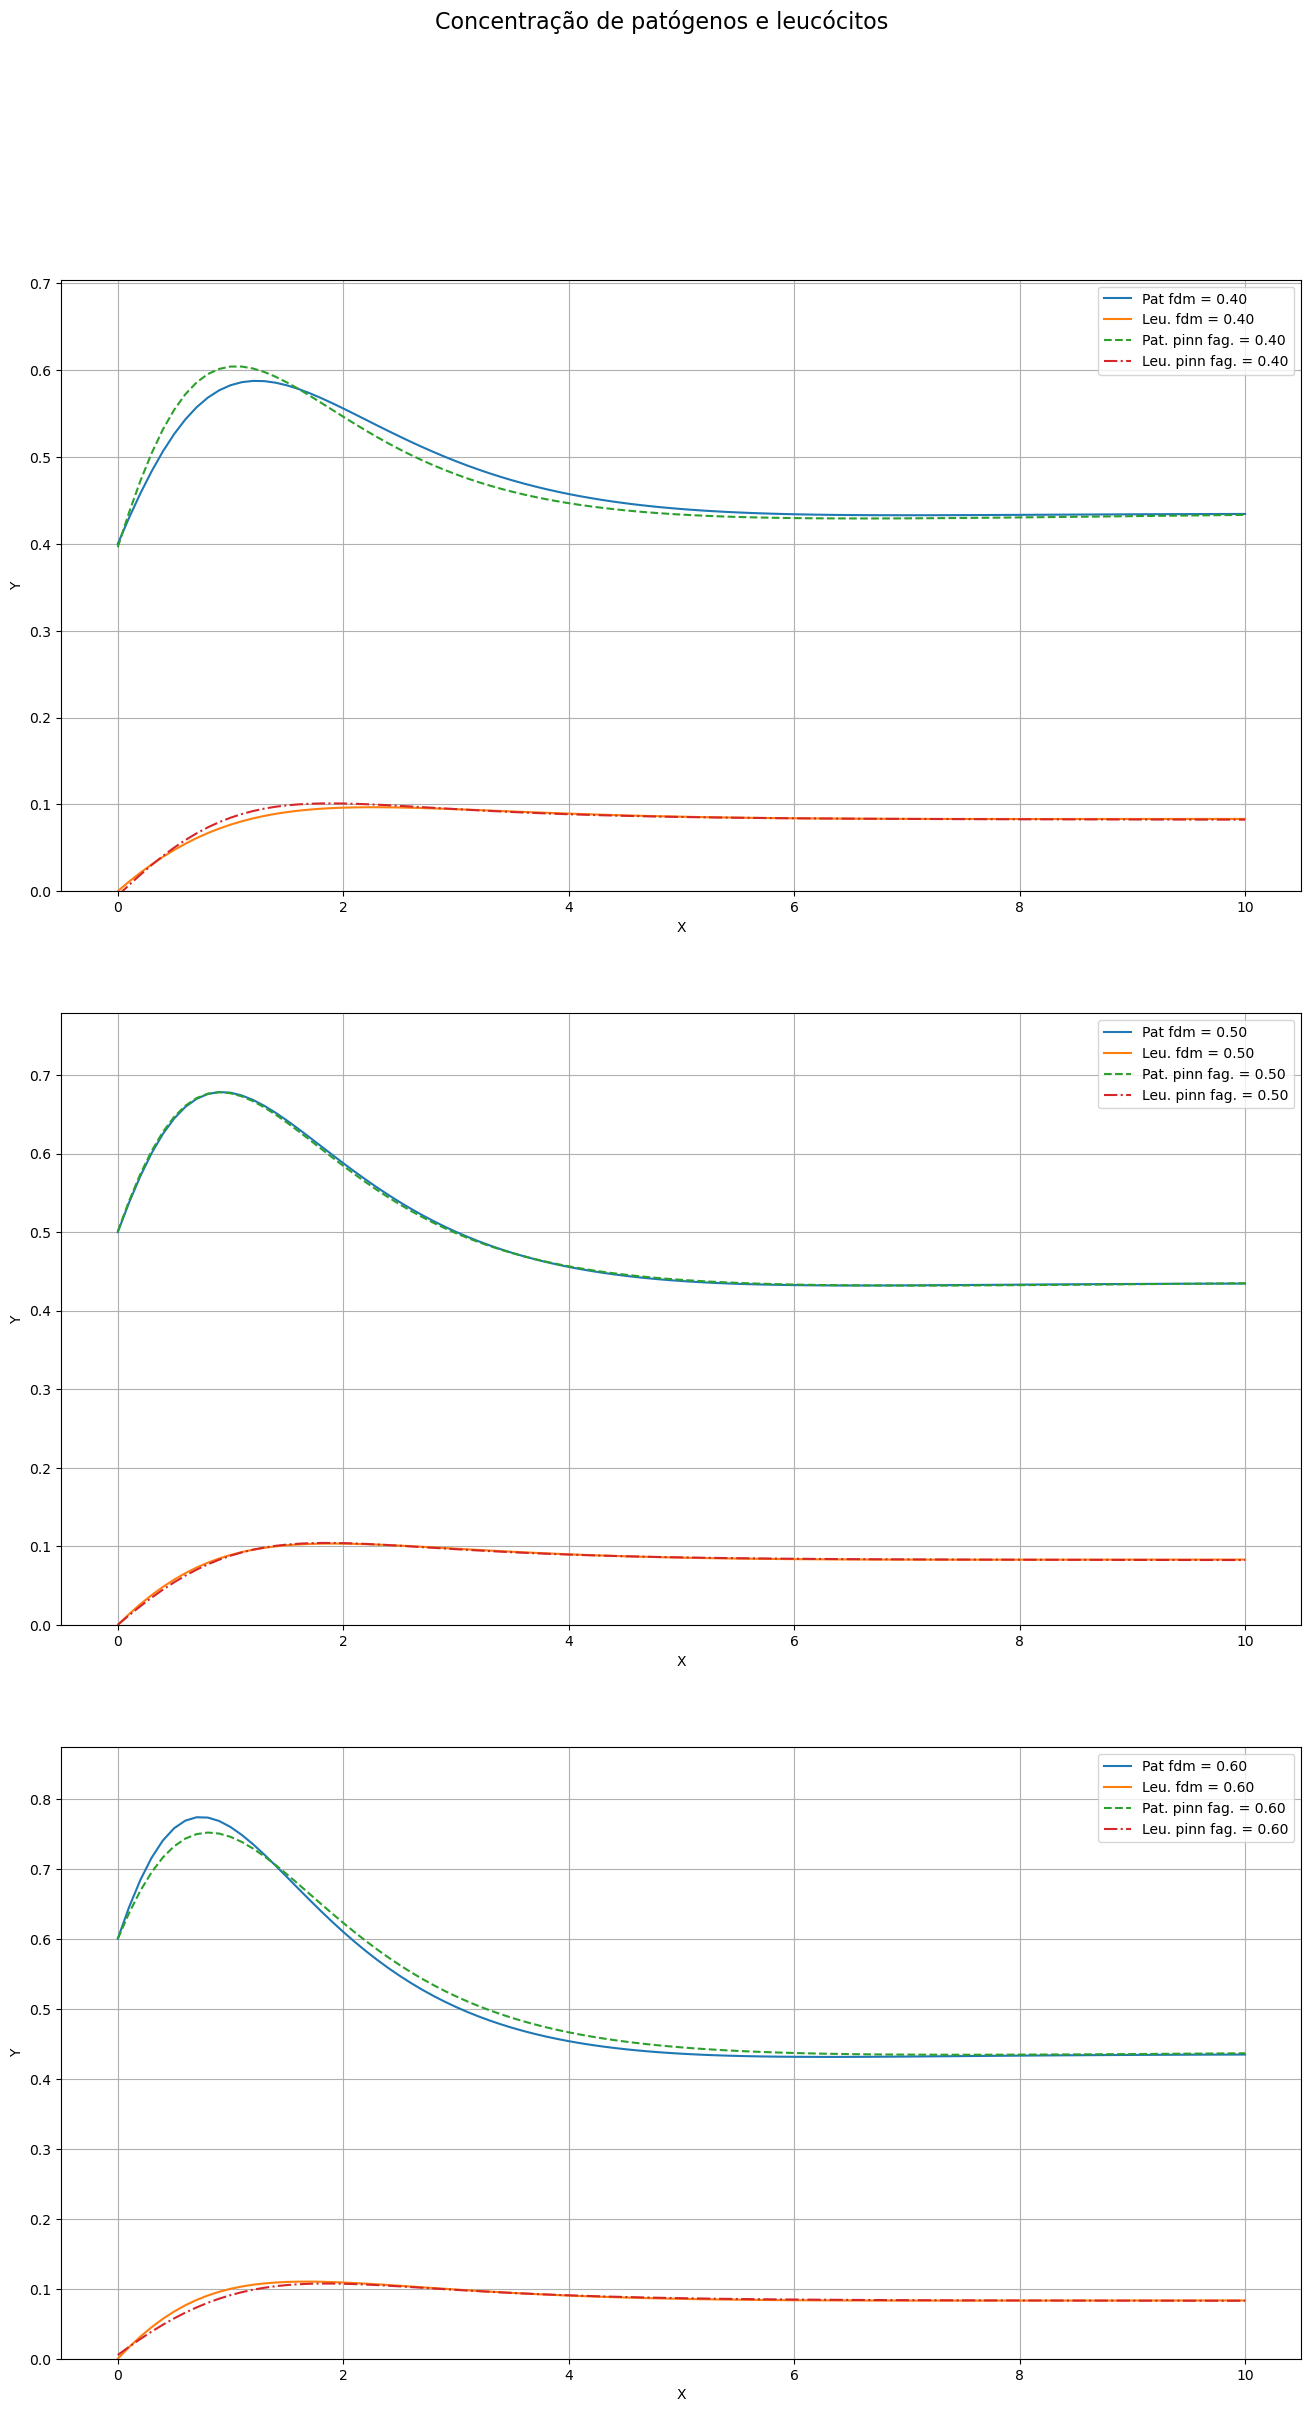

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp_old[0, :]
cl_real_1 = Cl_old[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
ini_1 = initial[0 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_2 = Cp_old[50, :]
cl_real_2 = Cl_old[50, :]
cp_pinn_2 = Cp_pinn_np[50, :]
cl_pinn_2 = Cl_pinn_np[50, :]
ini_2 = initial[50 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_3 = Cp_old[100, :]
cl_real_3 = Cl_old[100, :]
cp_pinn_3 = Cp_pinn_np[100, :]
cl_pinn_3 = Cl_pinn_np[100, :]
ini_3 = initial[100 * (size_t + 1)].cpu().detach().numpy()[0]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(ini_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(ini_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(ini_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(ini_2))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(ini_2))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(ini_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(ini_3))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(ini_3))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(ini_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()